In [420]:
import pickle
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cdo
from scipy.spatial import KDTree

SYNOP are stations measurements, TEMP radiosondes and dropsondes, AIREP aircrafts, PILOT ballon observations, DRIBU are buoys
d[5,:] are my runs, d[0,:] Ariannas

## Global Verification 

In [134]:
#reading in data

urb_00_synop = xr.open_dataset('../pickle_files/testurban_run2022061500SYNOP.nc')
urb_12_synop = xr.open_dataset('../pickle_files/testurban_run2022061512SYNOP.nc')

opr_00_synop = xr.open_dataset('../pickle_files/testoperational_run2022061500SYNOP.nc')
opr_12_synop = xr.open_dataset('../pickle_files/testoperational_run2022061512SYNOP.nc')

urb_00_pilot = xr.open_dataset('../pickle_files/testurban_run2022061500PILOT.nc')
urb_12_pilot = xr.open_dataset('../pickle_files/testurban_run2022061512PILOT.nc')

opr_00_pilot = xr.open_dataset('../pickle_files/testoperational_run2022061500PILOT.nc')
opr_12_pilot = xr.open_dataset('../pickle_files/testoperational_run2022061512PILOT.nc')

urb_00_temp = xr.open_dataset('../pickle_files/testurban_run2022061500TEMP.nc')
urb_12_temp = xr.open_dataset('../pickle_files/testurban_run2022061512TEMP.nc')

opr_00_temp = xr.open_dataset('../pickle_files/testoperational_run2022061500TEMP.nc')
opr_12_temp = xr.open_dataset('../pickle_files/testoperational_run2022061512TEMP.nc')



In [421]:
opr_12_pilot.veri_description.values

array([b'first guess                                                     ',
       b'first guess error                                               ',
       b'analysis in observation space                                   ',
       b'3dvar analysis                                                  ',
       b'VQC weight                                                      ',
       b'forecast vv= 1200                                               '],
      dtype='|S64')

In [74]:
opr_12_temp.veri_description.values

array([b'first guess                                                     ',
       b'first guess error                                               ',
       b'analysis in observation space                                   ',
       b'3dvar analysis                                                  ',
       b'VQC weight                                                      ',
       b'forecast vv= 1200                                               '],
      dtype='|S64')

In [68]:
#bug check, see if files are different from each other

urb_00_synop_modified = urb_00_synop.copy()
opr_00_synop_modified = opr_00_synop.copy()

urb_00_synop_modified.attrs.pop('history', None)
opr_00_synop_modified.attrs.pop('history', None)

xr.testing.assert_identical(urb_00_synop_modified, opr_00_synop_modified)
print('The datasets are equal, excluding history')

AssertionError: Left and right Dataset objects are not identical


Differing data variables:
L   veri_data         (d_veri, d_body) float32 0.841 -7.325 ... 57.95 0.8013
    longname: modelled quantity (as indicated by veri_ens_member)
R   veri_data         (d_veri, d_body) float32 0.841 -7.325 ... 57.93 0.8013
    longname: modelled quantity (as indicated by veri_ens_member)


In [136]:
#same bug check

urb_12_pilot_modified = urb_12_pilot.copy()
opr_12_pilot_modified = opr_12_pilot.copy()

urb_12_pilot_modified.attrs.pop('history', None)
opr_12_pilot_modified.attrs.pop('history', None)

xr.testing.assert_identical(urb_12_pilot_modified, opr_12_pilot_modified)
print('The datasets are equal, excluding history')

AssertionError: Left and right Dataset objects are not identical


Differing data variables:
L   veri_data         (d_veri, d_body) float32 -2.984 0.9247 ... 24.49 4.289
    longname: modelled quantity (as indicated by veri_ens_member)
R   veri_data         (d_veri, d_body) float32 -2.984 0.9247 ... 24.6 4.298
    longname: modelled quantity (as indicated by veri_ens_member)


## Global Verification

In [70]:
#set the style

sns.set_style('whitegrid')

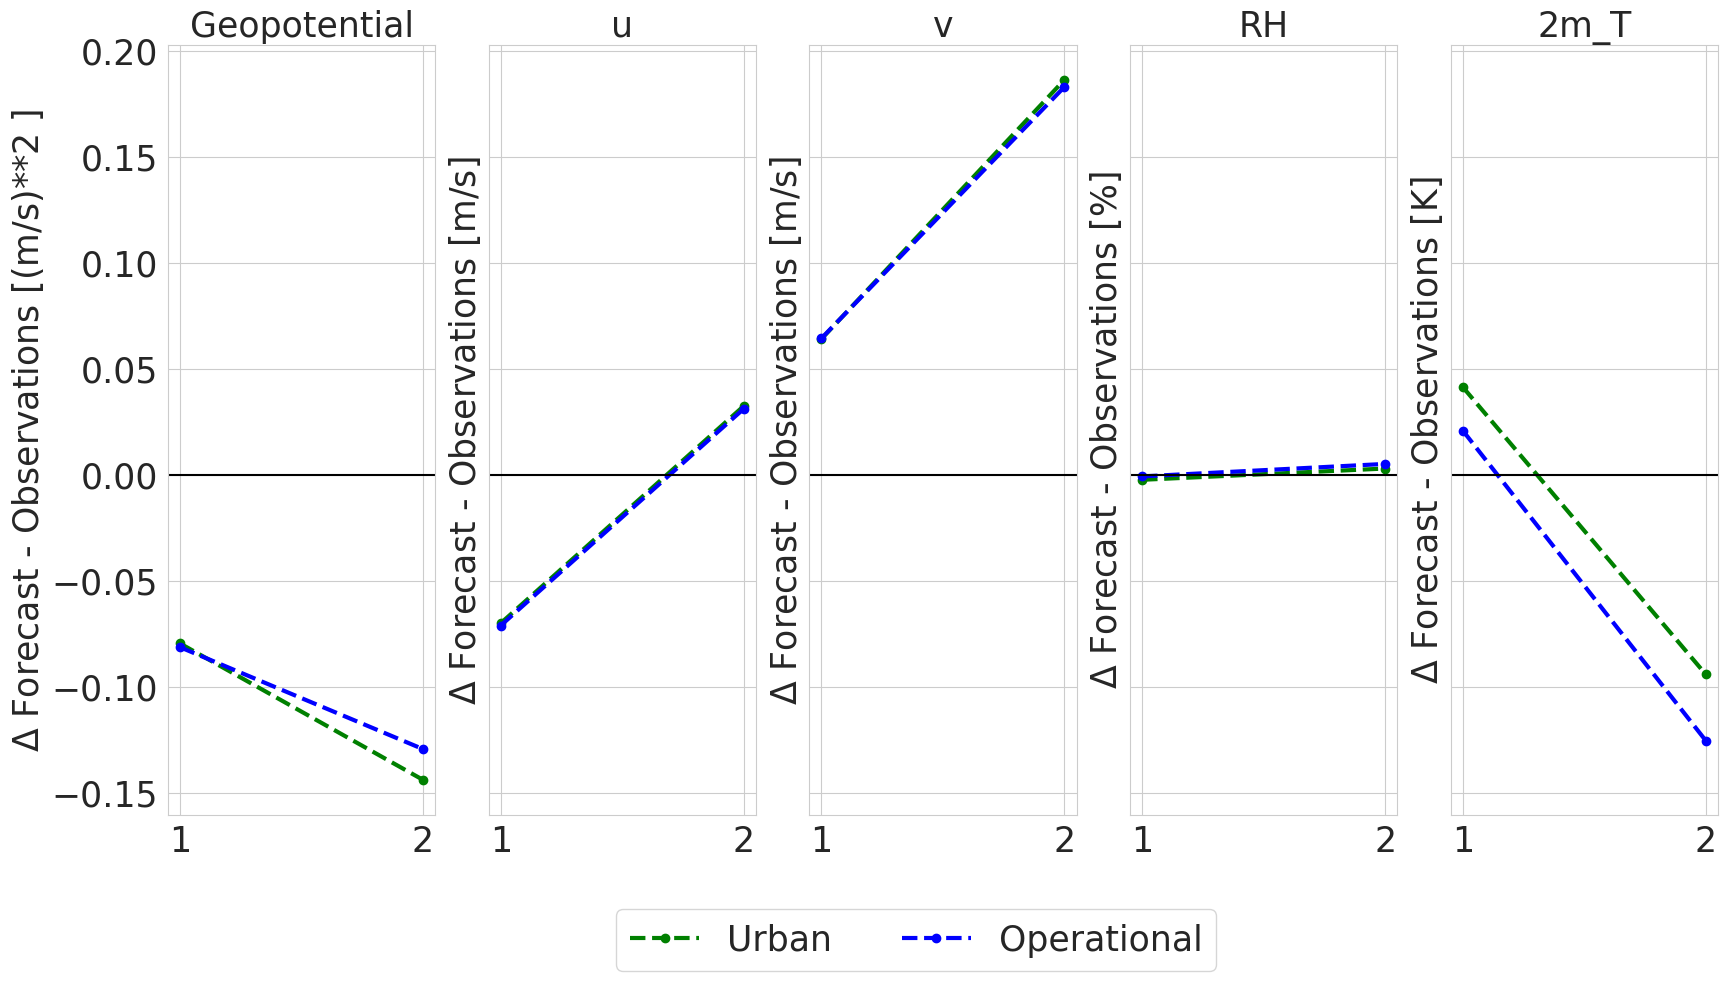

In [422]:
#plot synop stations - measurements global

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_synop.varno)
varno = ['Geopotential', 'u', 'v', 'RH', '2m_T']
y_label = ['(m/s)**2 ', 'm/s', 'm/s', '%','K']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_synop,
    'urban_00h': urb_00_synop,
    'operational_12h': opr_12_synop,
    'urban_12h': urb_12_synop,}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', color='g', linestyle='--', linewidth=3, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', color='b', linestyle='--', linewidth=3, label='Operational')
#    ax[i].plot([1, 2], [opr_00_3hlt, opr_12_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational \n (3h lead time)')
    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
#    ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

#ax[-1].legend(loc='upper right', bbox_to_anchor=(0, -.5))
ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -0.1), ncol=3)

#plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


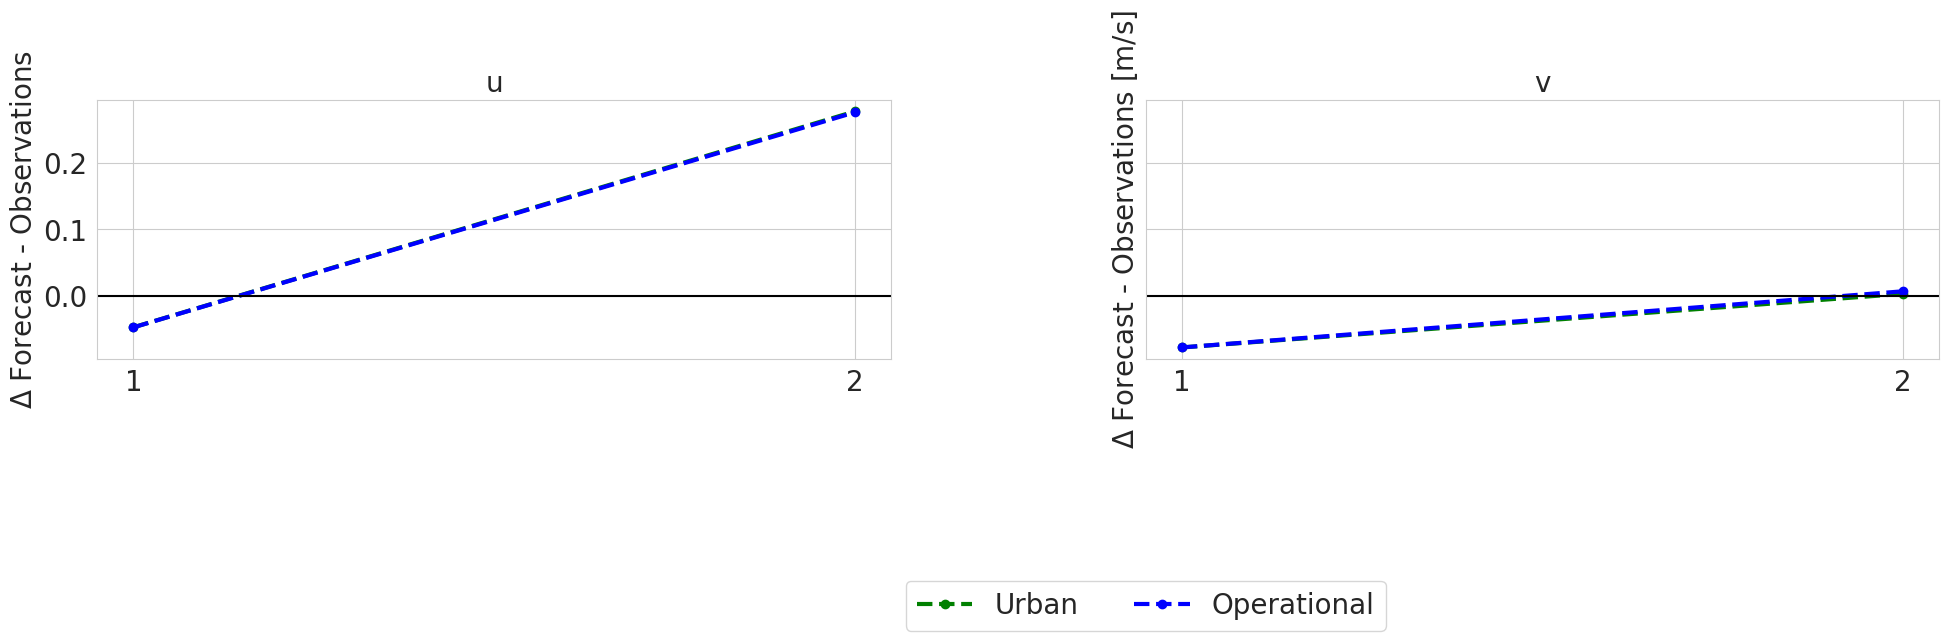

In [152]:
#plot PILOT - ballon observations globally

params = {'axes.labelsize': 20,'axes.titlesize':20, 'legend.fontsize': 20, 'xtick.labelsize': 20, 
          'ytick.labelsize': 20}

plt.rcParams.update(params)

x = np.unique(urb_12_pilot.varno)
varno = ['u', 'v']
y_label = ['m/s', 'm/s']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_pilot,
    'urban_00h': urb_00_pilot,
    'operational_12h': opr_12_pilot,
    'urban_12h': urb_12_pilot,
}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', color='g', linestyle='--', linewidth=3, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', color='b', linestyle='--', linewidth=3, label='Operational')
#    ax[i].plot([1, 2], [opr_12_3hlt, opr_24_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational 3h leadtime')
    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
    ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

ax[0].set_ylabel('$\Delta$ Forecast - Observations')
ax[-1].legend(loc='upper center', bbox_to_anchor=(0, -0.8), ncol=3)

plt.tight_layout()
plt.show()


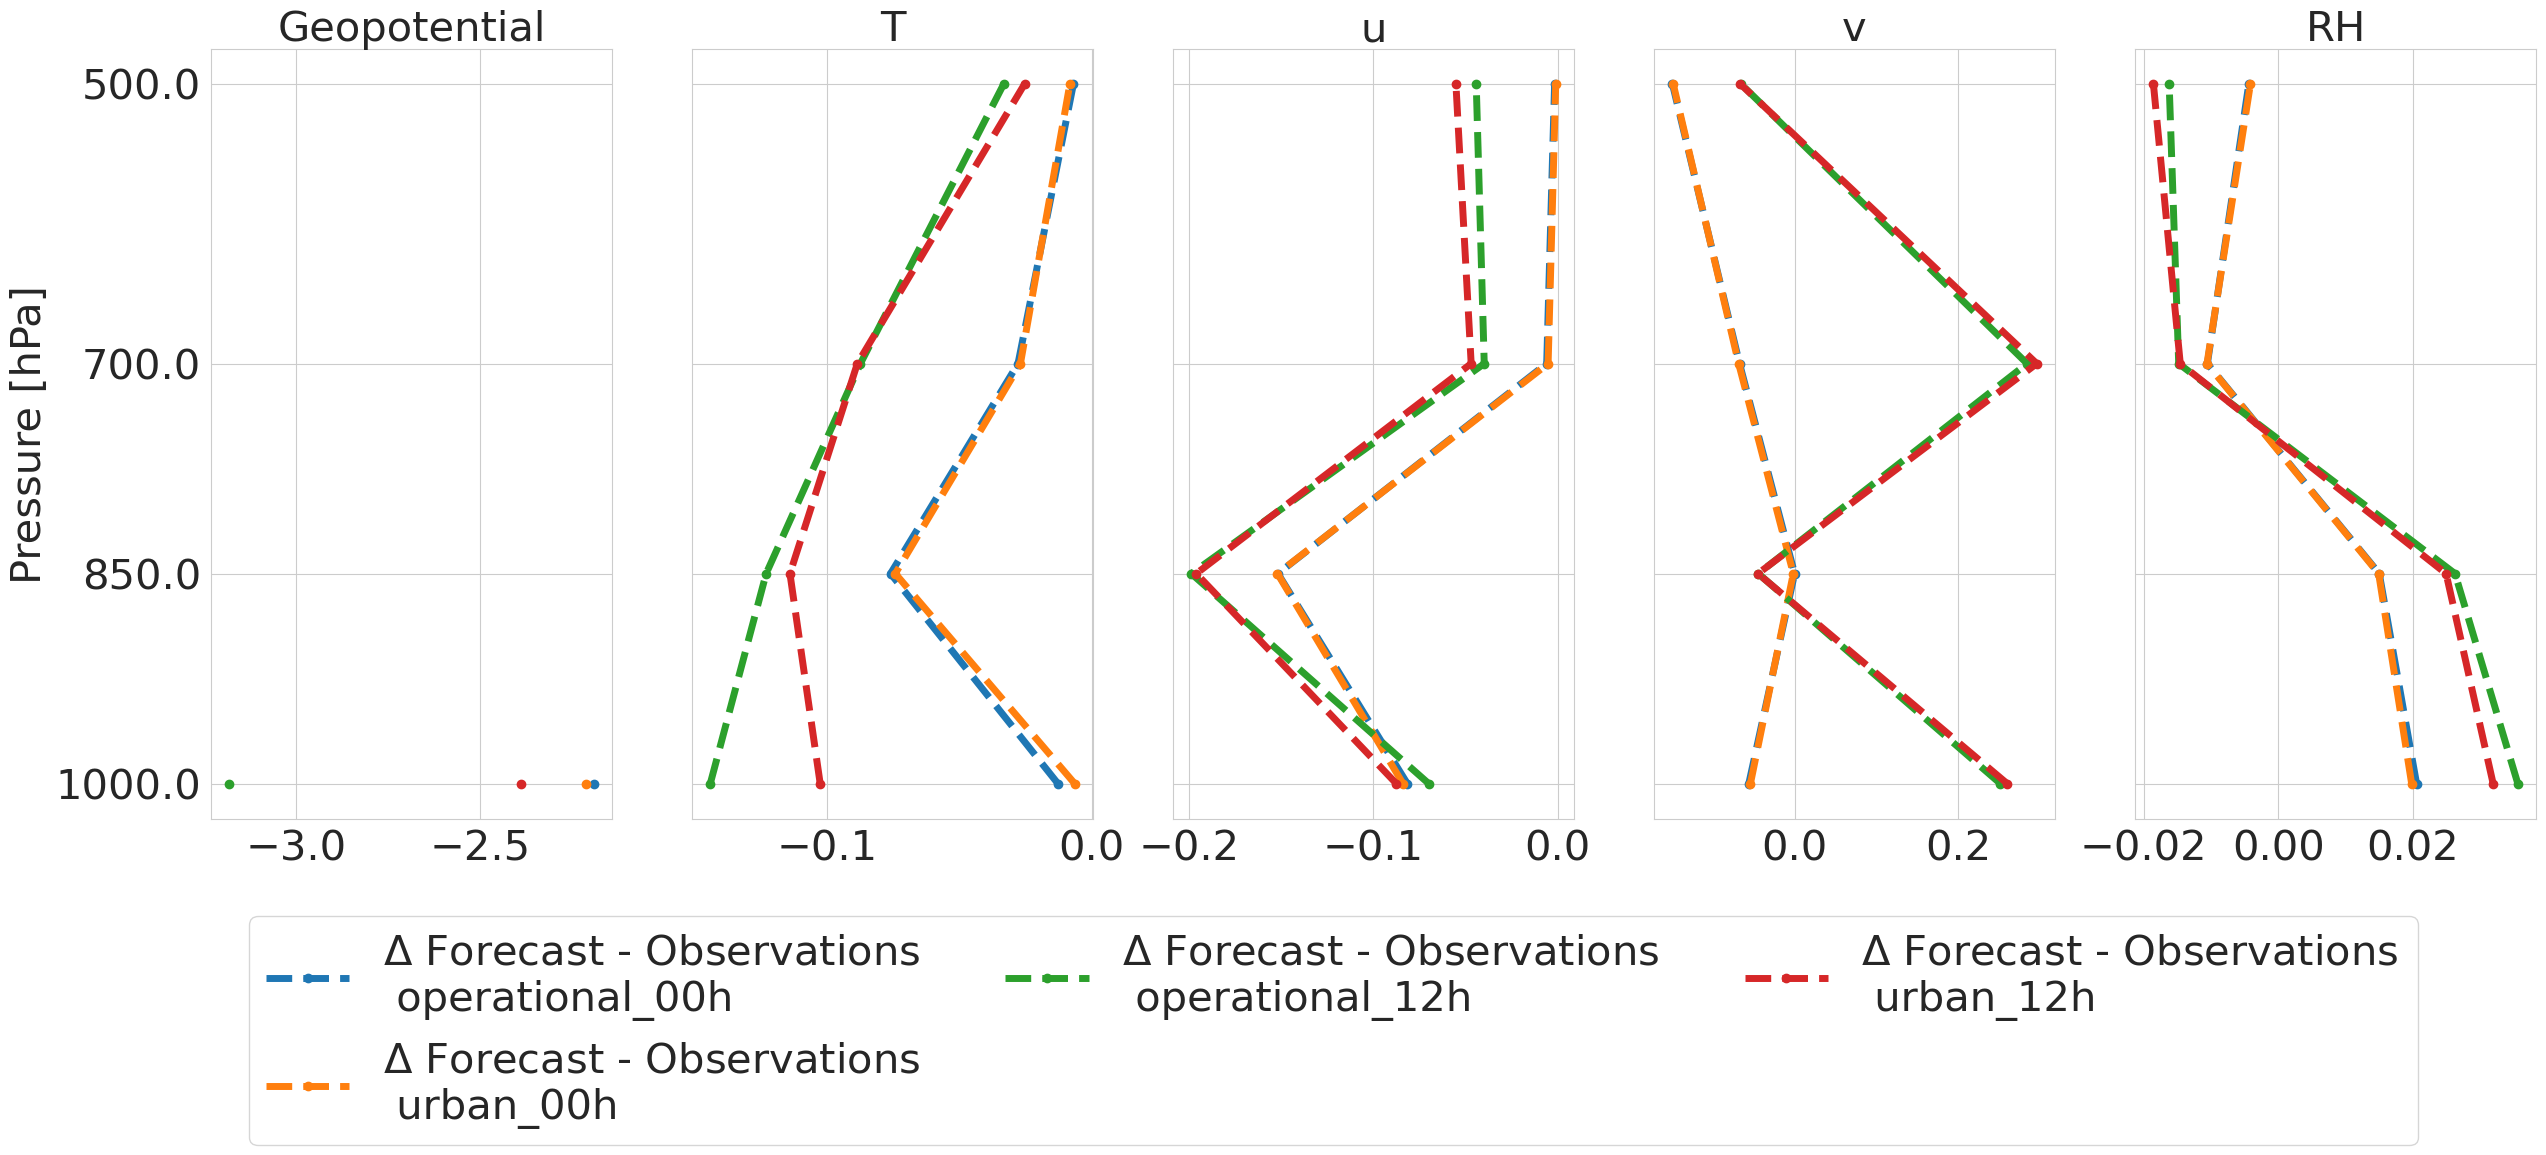

In [169]:
#plot radiosondes and dropsondes globally

params = {'axes.labelsize': 30,'axes.titlesize':30, 'legend.fontsize': 30, 'xtick.labelsize': 30, 
          'ytick.labelsize': 30}

plt.rcParams.update(params)

p_levels = [100000, 85000, 70000, 50000]
x = np.unique(opr_00_temp.varno)
varno = ['Geopotential', 'T', 'u', 'v', 'RH']

fig, ax = plt.subplots(1, len(x), figsize=(30, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_temp,
    'urban_00h': urb_00_temp,
}

datasets_12 = {
    'operational_12h': opr_12_temp,
    'urban_12h': urb_12_temp,
}

for i, x_value in enumerate(x):
    for label, data in datasets_00.items():
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', linestyle='--', linewidth =5,  label=f'$\Delta$ Forecast - Observations \n {label}')

    for label, data in datasets_12.items():
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', linestyle='--', linewidth = 5, label=f'$\Delta$ Forecast - Observations \n {label}')

#    for label, data in datasets_00.items():
#        diff_data = [data.veri_data[0, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
#        ax[i].plot(diff_data, p_levels, marker='o', linestyle='--', linewidth = 3, label=label)
        

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{p / 100}' for p in p_levels])

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -.1), ncol=3)


plt.gca().invert_yaxis()
plt.show()

## European Verification

xr.sel would be a more elegant way to slice the data, but it doesn't work, since lat lon are non-indexed multidimensional coordinates. It is discussed here
https://github.com/pydata/xarray/issues/2028

In [162]:
#filter european domain by where command with lon lat valules

urb_00_pilot_europe = urb_00_pilot.where((urb_00_pilot.lat >= 20) & (urb_00_pilot.lat <= 80) & (urb_00_pilot.lon >= -10) & (urb_00_pilot.lon <= 30), drop=True)
urb_12_pilot_europe = urb_12_pilot.where((urb_12_pilot.lat >= 20) & (urb_12_pilot.lat <= 80) & (urb_12_pilot.lon >= -10) & (urb_12_pilot.lon <= 30), drop=True)

opr_00_pilot_europe = opr_00_pilot.where((opr_00_pilot.lat >= 20) & (opr_00_pilot.lat <= 80) & (opr_00_pilot.lon >= -10) & (opr_00_pilot.lon <= 30), drop=True)
opr_12_pilot_europe = opr_12_pilot.where((opr_12_pilot.lat >= 20) & (opr_12_pilot.lat <= 80) & (opr_12_pilot.lon >= -10) & (opr_12_pilot.lon <= 30), drop=True)

urb_00_synop_europe = urb_00_synop.where((urb_00_synop.lat >= 20) & (urb_00_synop.lat <= 80) & (urb_00_synop.lon >= -10) & (urb_00_synop.lon <= 30), drop=True)
urb_12_synop_europe = urb_12_synop.where((urb_12_synop.lat >= 20) & (urb_12_synop.lat <= 80) & (urb_12_synop.lon >= -10) & (urb_12_synop.lon <= 30), drop=True)

opr_00_synop_europe = opr_00_synop.where((opr_00_synop.lat >= 20) & (opr_00_synop.lat <= 80) & (opr_00_synop.lon >= -10) & (opr_00_synop.lon <= 30), drop=True)
opr_12_synop_europe = opr_12_synop.where((opr_12_synop.lat >= 20) & (opr_12_synop.lat <= 80) & (opr_12_synop.lon >= -10) & (opr_12_synop.lon <= 30), drop=True)

urb_00_temp_europe = urb_00_temp.where((urb_00_temp.lat >= 20) & (urb_00_temp.lat <= 80) & (urb_00_temp.lon >= -10) & (urb_00_temp.lon <= 30), drop=True)
urb_12_temp_europe = urb_12_temp.where((urb_12_temp.lat >= 20) & (urb_12_temp.lat <= 80) & (urb_12_temp.lon >= -10) & (urb_12_temp.lon <= 30), drop=True)

opr_00_temp_europe = opr_00_temp.where((opr_00_temp.lat >= 20) & (opr_00_temp.lat <= 80) & (opr_00_temp.lon >= -10) & (opr_00_temp.lon <= 30), drop=True)
opr_12_temp_europe = opr_12_temp.where((opr_12_temp.lat >= 20) & (opr_12_temp.lat <= 80) & (opr_12_temp.lon >= -10) & (opr_12_temp.lon <= 30), drop=True)

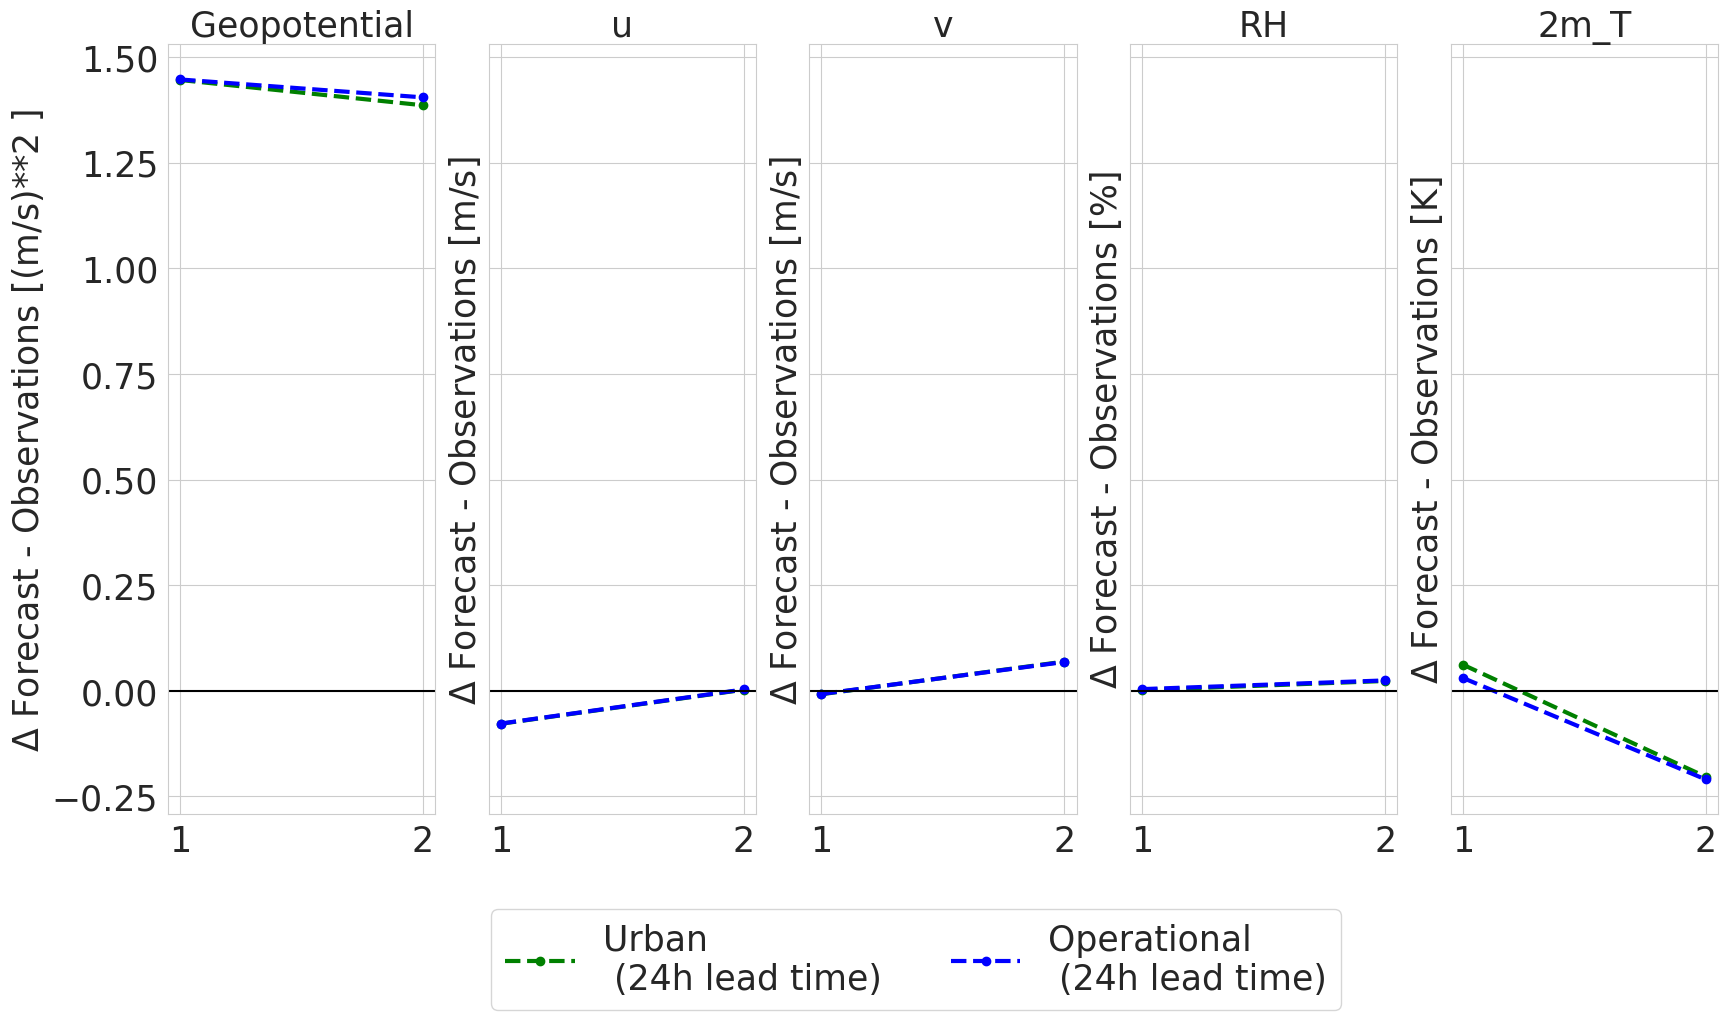

In [166]:
# plot SYNOP measurement stations - for Europe

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_synop.varno)
varno = ['Geopotential', 'u', 'v', 'RH', '2m_T']
y_label = ['(m/s)**2 ', 'm/s', 'm/s', '%','K']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_synop_europe,
    'urban_00h': urb_00_synop_europe,
    'operational_12h': opr_12_synop_europe,
    'urban_12h': urb_12_synop_europe,}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', color='g', linestyle='--', linewidth=3, label='Urban \n (24h lead time)')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', color='b', linestyle='--', linewidth=3, label='Operational \n (24h lead time)')
#    ax[i].plot([1, 2], [opr_00_3hlt, opr_12_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational \n (3h lead time)')
    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
#    ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

#ax[-1].legend(loc='upper right', bbox_to_anchor=(0, -.5))
ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -0.1), ncol=3)

#plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


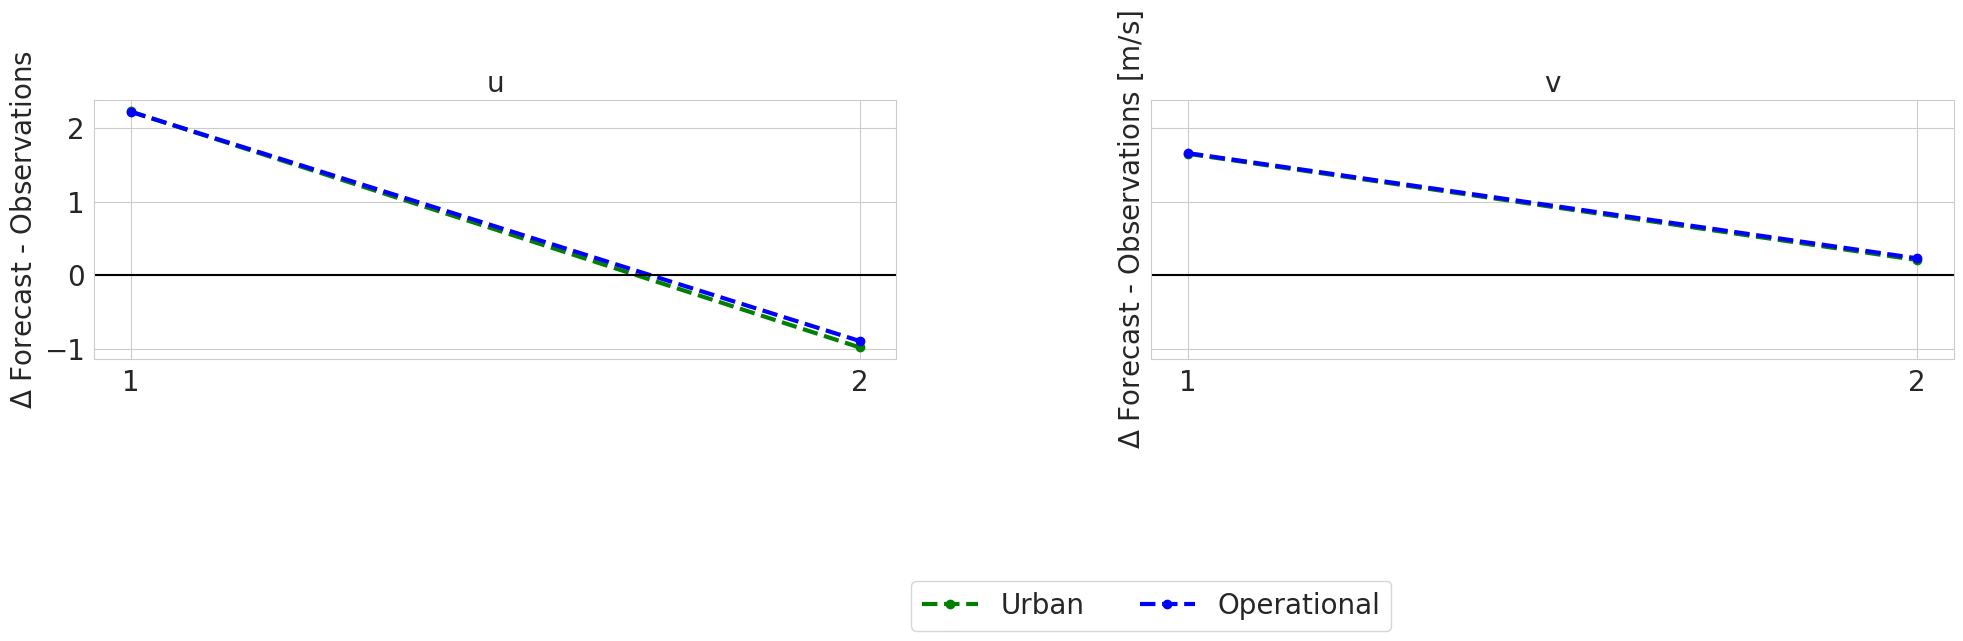

In [165]:
#plot Ballon observations - for Europe

params = {'axes.labelsize': 20,'axes.titlesize':20, 'legend.fontsize': 20, 'xtick.labelsize': 20, 
          'ytick.labelsize': 20}

plt.rcParams.update(params)

x = np.unique(urb_12_pilot.varno)
varno = ['u', 'v']
y_label = ['m/s', 'm/s']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_pilot_europe,
    'urban_00h': urb_00_pilot_europe,
    'operational_12h': opr_12_pilot_europe,
    'urban_12h': urb_12_pilot_europe,
}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', color='g', linestyle='--', linewidth=3, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', color='b', linestyle='--', linewidth=3, label='Operational')
#    ax[i].plot([1, 2], [opr_12_3hlt, opr_24_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational 3h leadtime')
    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
    ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

ax[0].set_ylabel('$\Delta$ Forecast - Observations')
ax[-1].legend(loc='upper center', bbox_to_anchor=(0, -0.8), ncol=3)

plt.tight_layout()
plt.show()


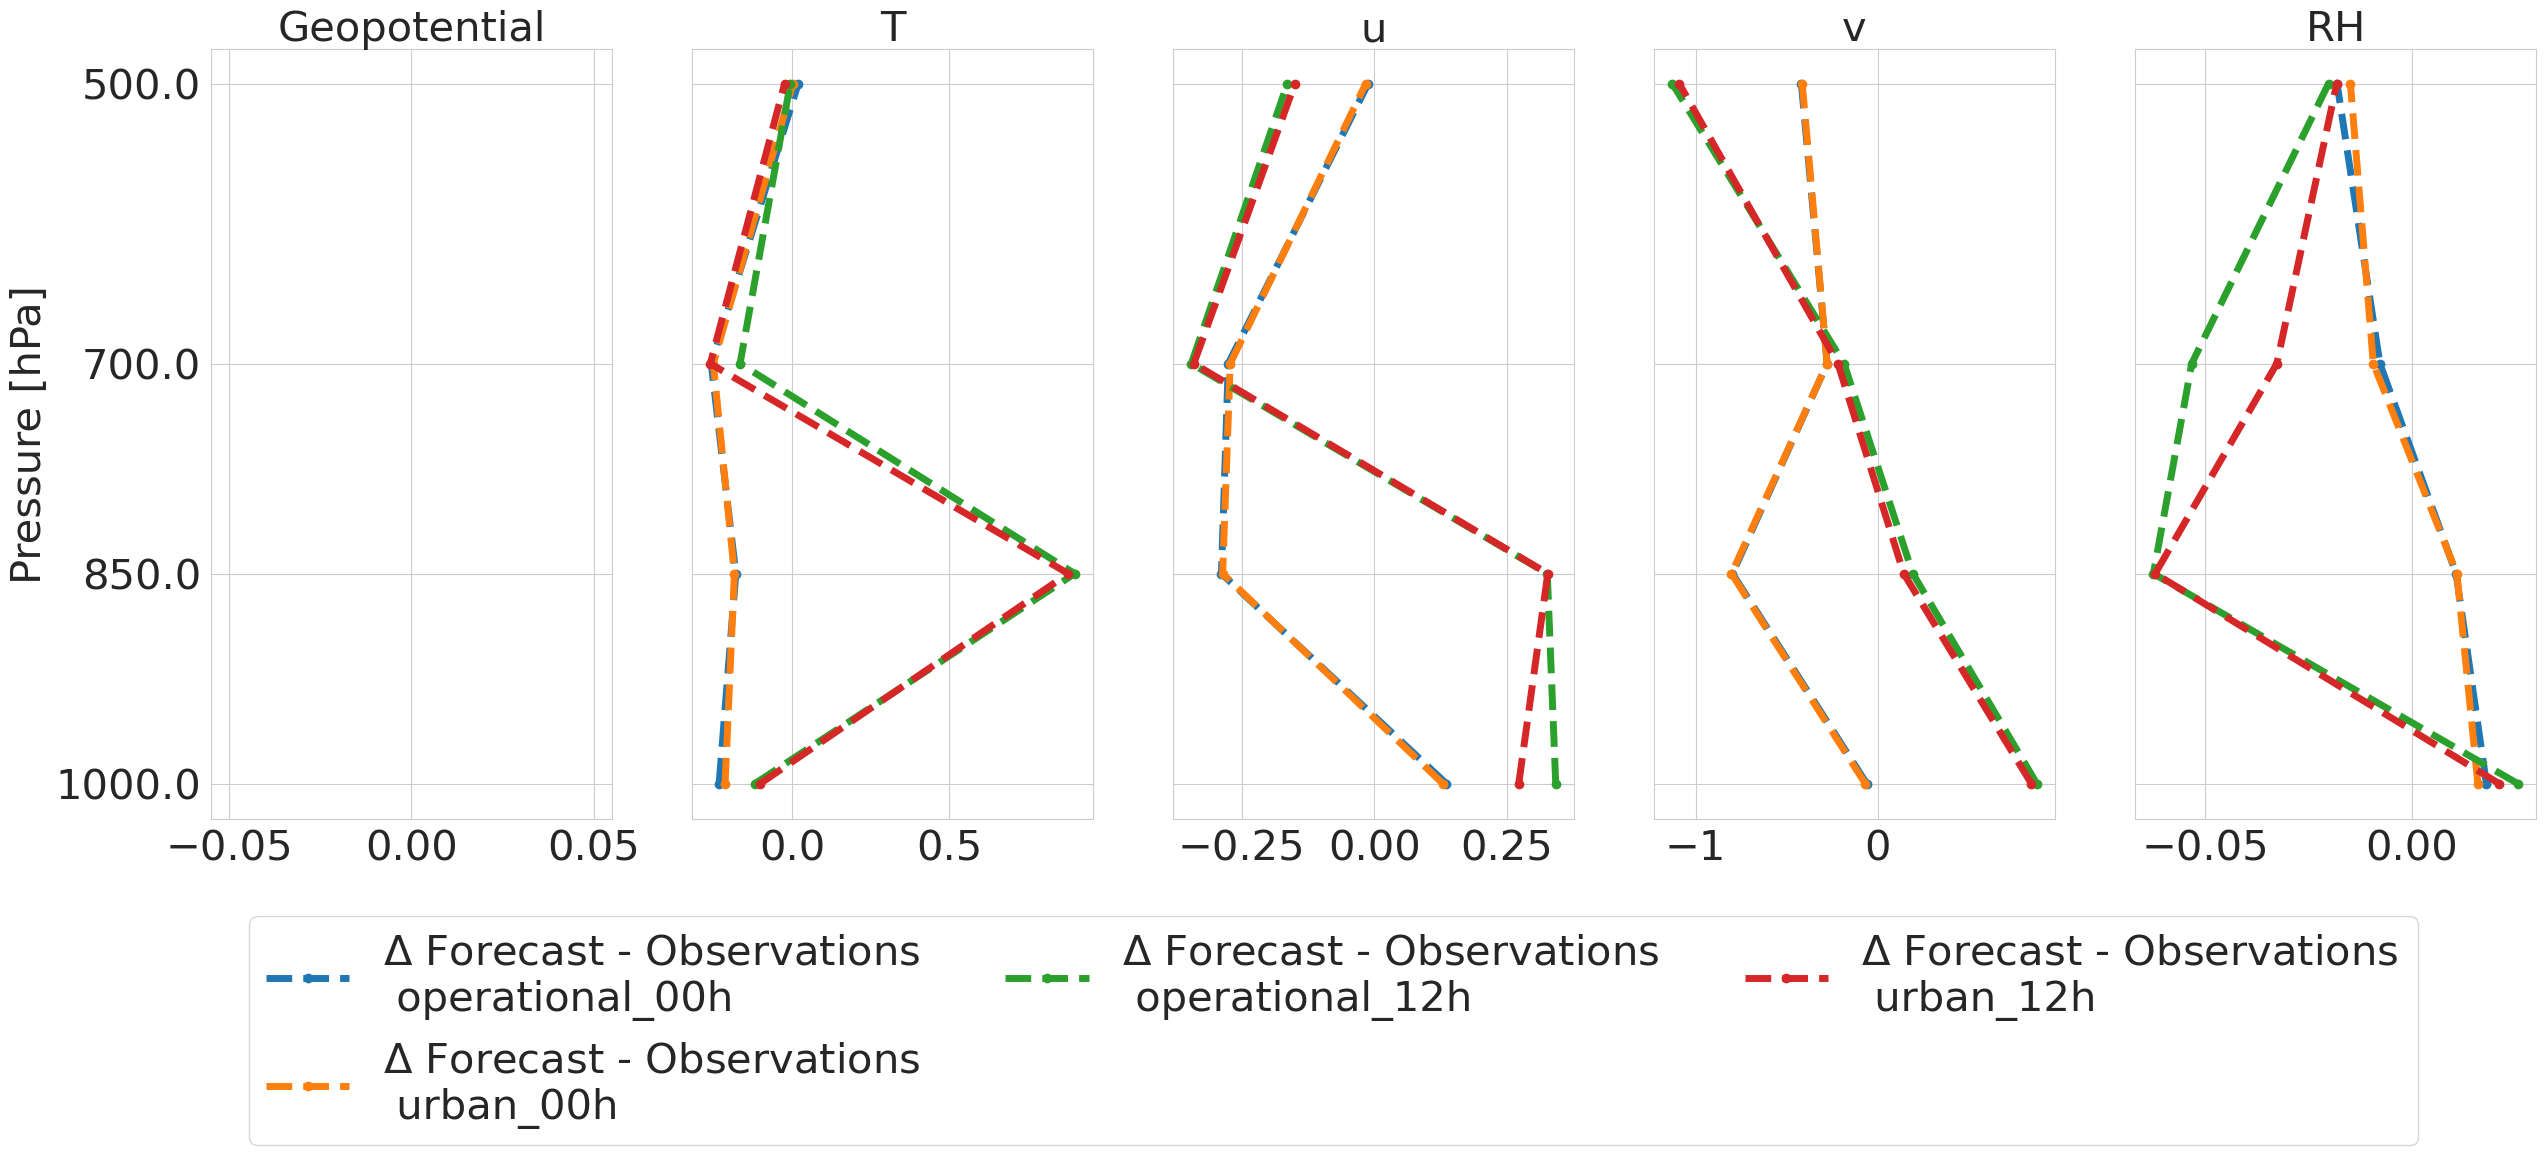

In [168]:
#plot radiosondes and dropsondes - for Europe

params = {'axes.labelsize': 30,'axes.titlesize':30, 'legend.fontsize': 30, 'xtick.labelsize': 30, 
          'ytick.labelsize': 30}

plt.rcParams.update(params)

p_levels = [100000, 85000, 70000, 50000]
x = np.unique(opr_00_temp.varno)
varno = ['Geopotential', 'T', 'u', 'v', 'RH']

fig, ax = plt.subplots(1, len(x), figsize=(30, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_temp_europe,
    'urban_00h': urb_00_temp_europe,
}

datasets_12 = {
    'operational_12h': opr_12_temp_europe,
    'urban_12h': urb_12_temp_europe,
}

for i, x_value in enumerate(x):
    for label, data in datasets_00.items():
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', linestyle='--', linewidth =5,  label=f'$\Delta$ Forecast - Observations \n {label}')

    for label, data in datasets_12.items():
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', linestyle='--', linewidth = 5, label=f'$\Delta$ Forecast - Observations \n {label}')

#    for label, data in datasets_00.items():
#        diff_data = [data.veri_data[0, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
#        ax[i].plot(diff_data, p_levels, marker='o', linestyle='--', linewidth = 3, label=label)
        

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{p / 100}' for p in p_levels])

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -.1), ncol=3)


plt.gca().invert_yaxis()
plt.show()

## Urban Grids Verification

In [213]:
#load dataset with lon lat values of cities, defined before

ds_det = xr.open_dataset('../det_data_all_2022/fc_DOM01_0001_NU_urban_grid.nc')

In [214]:
#select lon and lat values

ds_det["clat"] = np.degrees(ds_det["clat"])
ds_det["clon"] = np.degrees(ds_det["clon"])

In [215]:
#define K-D tree for the PILOT 00 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061500PILOT.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [216]:
#initialize K-D tree
tree_icon = model_kdtree()
tree_icon.kdtree

In [217]:
# apply tree to lat lon values from cities given abvoe

indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [218]:
# select accordingly in verification files

urb_00_pilot_cities = urb_00_pilot.isel(d_body=indices_cities_ens)
opr_00_pilot_cities = opr_00_pilot.isel(d_body=indices_cities_ens)

In [239]:
#define K-D tree for the PYLOT 12 data 

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061512PILOT.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [240]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [241]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [242]:
urb_12_pilot_cities = urb_12_pilot.isel(d_body=indices_cities_ens)
opr_12_pilot_cities = opr_12_pilot.isel(d_body=indices_cities_ens)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


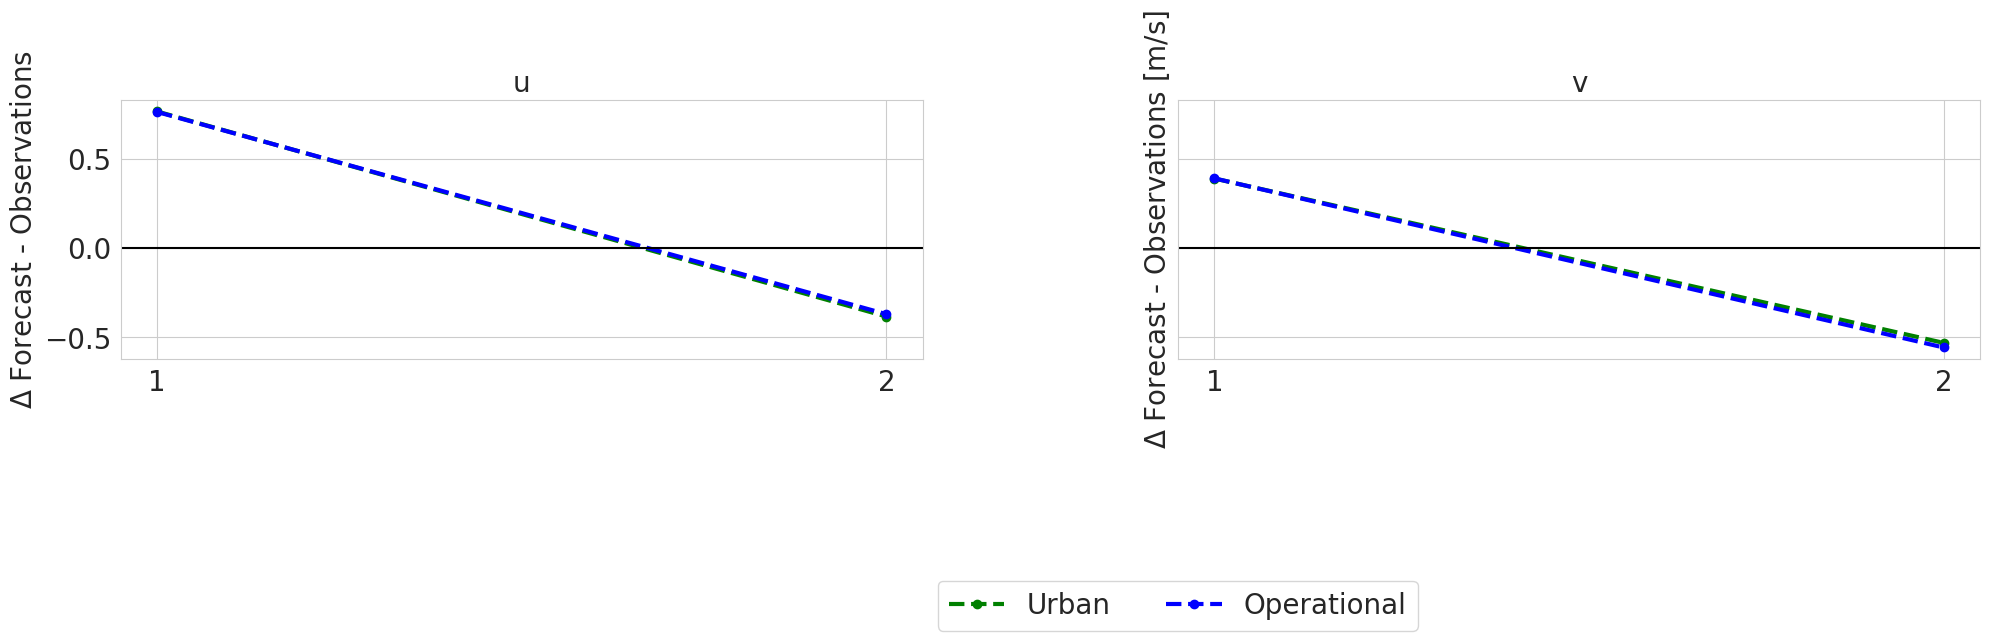

In [243]:
#plot ballon data - For cities worldwide

params = {'axes.labelsize': 20,'axes.titlesize':20, 'legend.fontsize': 20, 'xtick.labelsize': 20, 
          'ytick.labelsize': 20}

plt.rcParams.update(params)

x = np.unique(urb_12_pilot.varno)
varno = ['u', 'v']
y_label = ['m/s', 'm/s']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_pilot_cities,
    'urban_00h': urb_00_pilot_cities,
    'operational_12h': opr_12_pilot_cities,
    'urban_12h': urb_12_pilot_cities,
}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', color='g', linestyle='--', linewidth=3, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', color='b', linestyle='--', linewidth=3, label='Operational')
#    ax[i].plot([1, 2], [opr_12_3hlt, opr_24_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational 3h leadtime')
    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
    ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

ax[0].set_ylabel('$\Delta$ Forecast - Observations')
ax[-1].legend(loc='upper center', bbox_to_anchor=(0, -0.8), ncol=3)

plt.tight_layout()
plt.show()


In [244]:
#define K-D tree for the SYNOP 00 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061500SYNOP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [245]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [246]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [247]:
urb_00_synop_cities = urb_00_synop.isel(d_body=indices_cities_ens)
opr_00_synop_cities = opr_00_synop.isel(d_body=indices_cities_ens)

In [248]:
#define K-D tree for the SYNOP 12 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061512SYNOP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [249]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [250]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [251]:
urb_12_synop_cities = urb_12_synop.isel(d_body=indices_cities_ens)
opr_12_synop_cities = opr_12_synop.isel(d_body=indices_cities_ens)

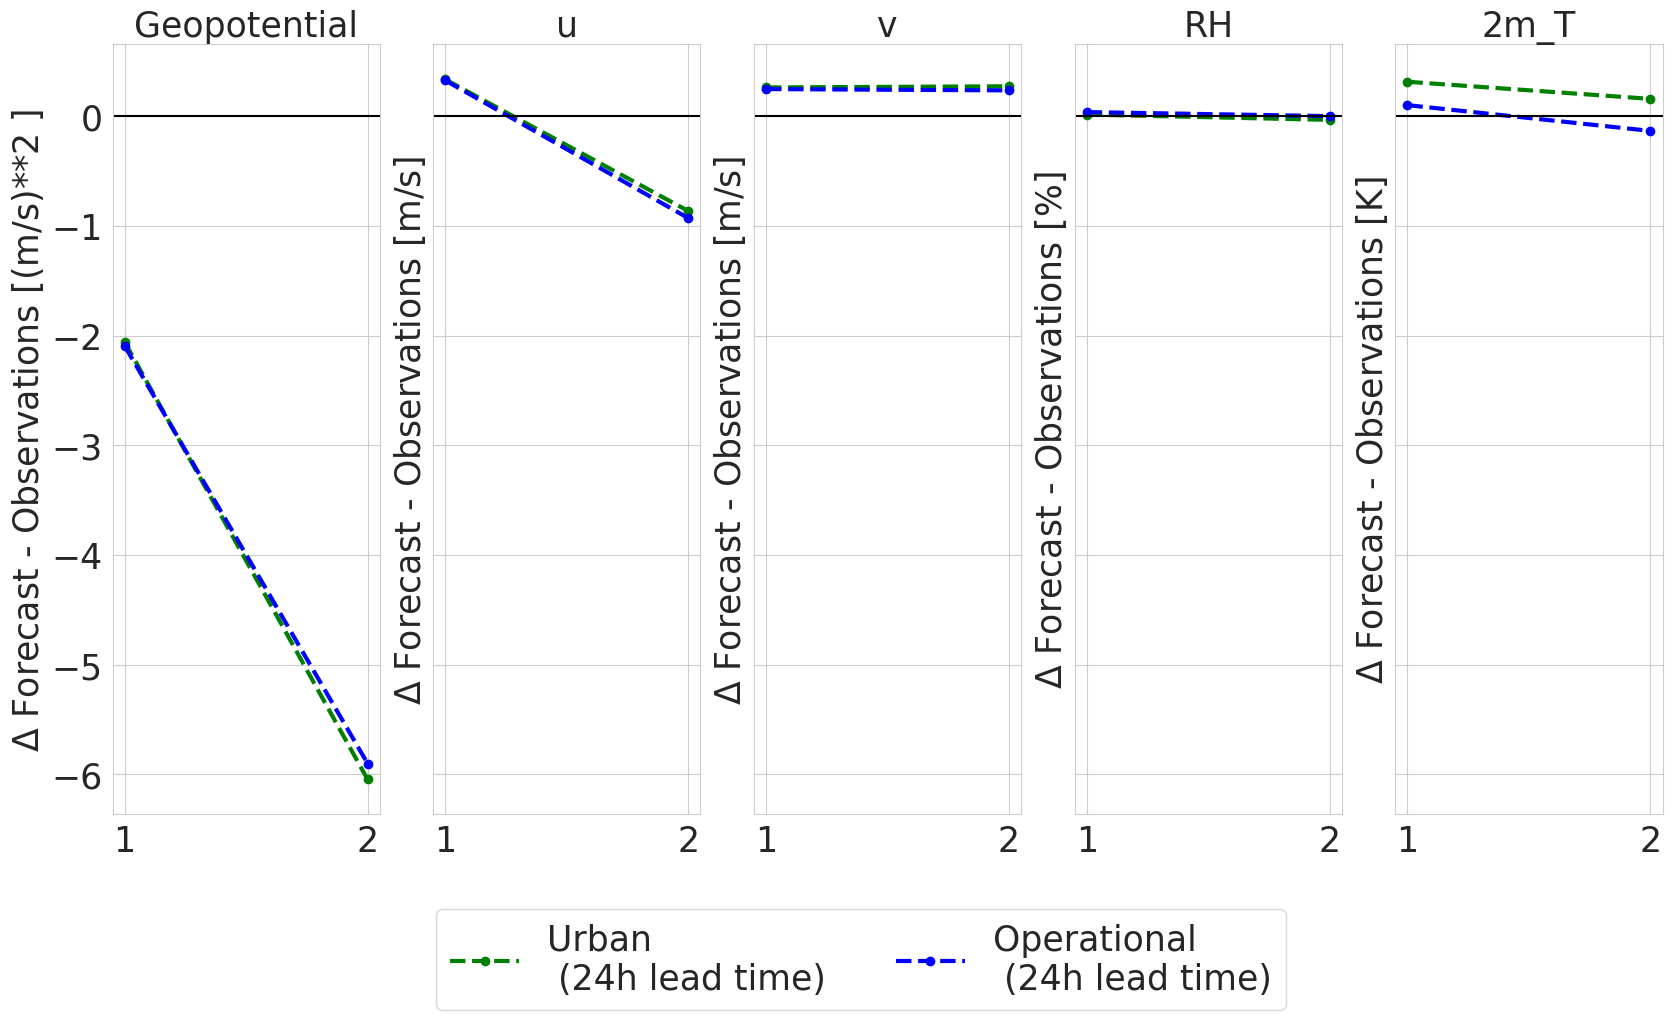

In [252]:
#plot SYNOP measurement data for cities worldwide

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_synop.varno)
varno = ['Geopotential', 'u', 'v', 'RH', '2m_T']
y_label = ['(m/s)**2 ', 'm/s', 'm/s', '%','K']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_synop_cities,
    'urban_00h': urb_00_synop_cities,
    'operational_12h': opr_12_synop_cities,
    'urban_12h': urb_12_synop_cities,}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', color='g', linestyle='--', linewidth=3, label='Urban \n (24h lead time)')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', color='b', linestyle='--', linewidth=3, label='Operational \n (24h lead time)')
#    ax[i].plot([1, 2], [opr_00_3hlt, opr_12_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational \n (3h lead time)')
    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
#    ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['1', '2'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

#ax[-1].legend(loc='upper right', bbox_to_anchor=(0, -.5))
ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -0.1), ncol=3)

#plt.tight_layout()
plt.show()


In [253]:
#define K-D tree for the TEMP 00 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061500TEMP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [254]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [255]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [256]:
urb_00_temp_cities = urb_00_temp.isel(d_body=indices_cities_ens)
opr_00_temp_cities = opr_00_temp.isel(d_body=indices_cities_ens)

In [257]:
#define K-D tree for the TEMP 12 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061512TEMP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [258]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [259]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [260]:
urb_12_temp_cities = urb_12_temp.isel(d_body=indices_cities_ens)
opr_12_temp_cities = opr_12_temp.isel(d_body=indices_cities_ens)

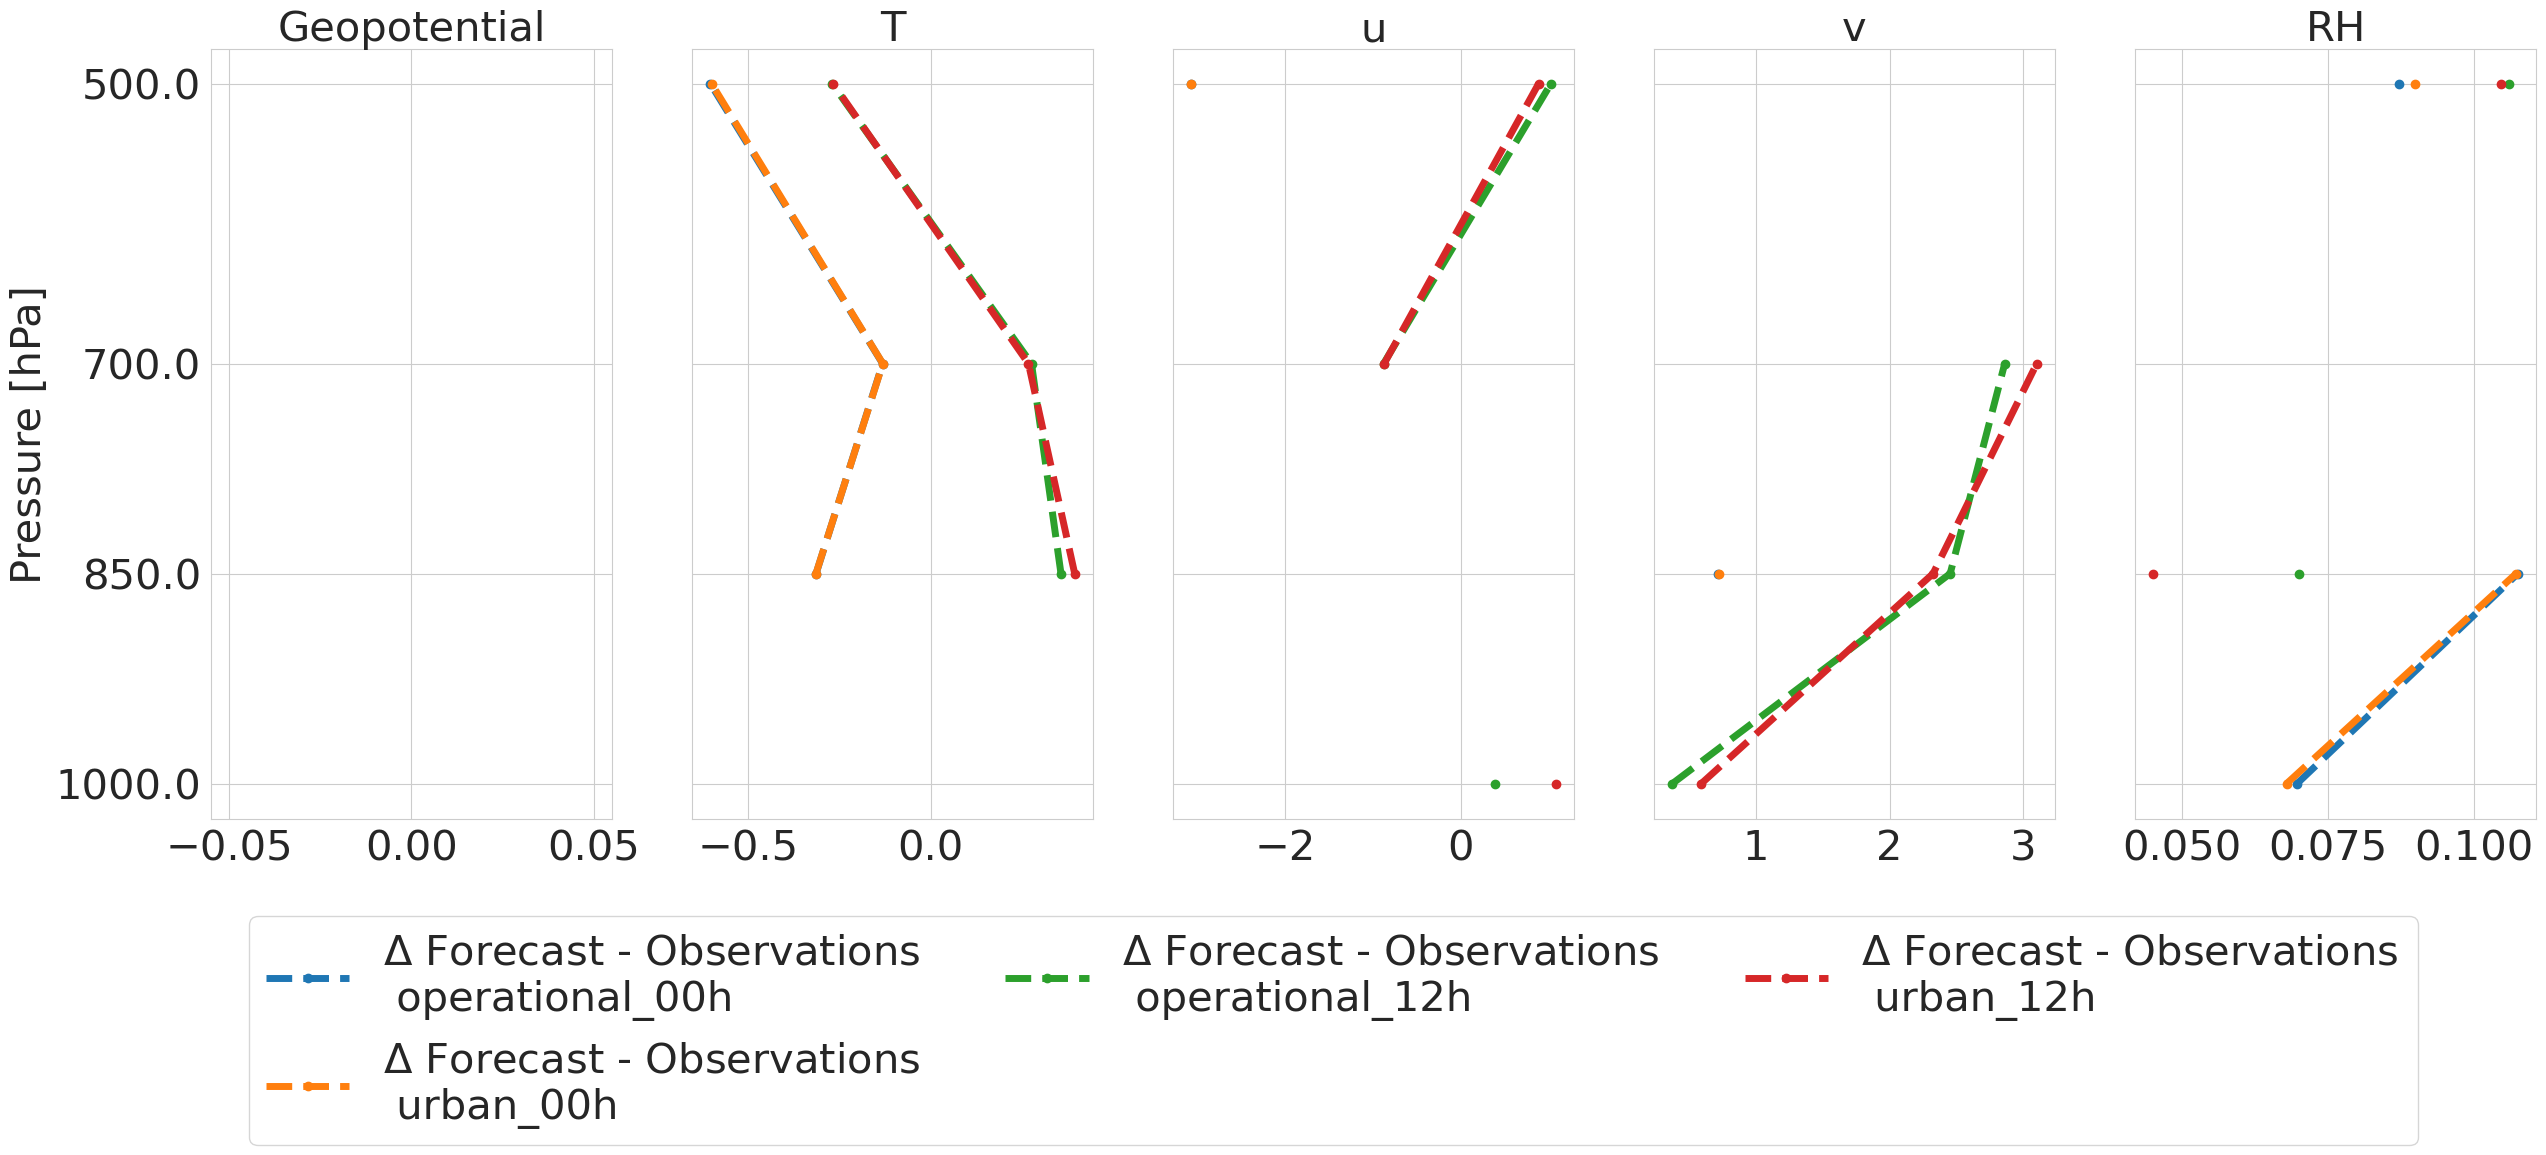

In [261]:
#plot radiosondes and dropsondes for cities worldwide

params = {'axes.labelsize': 30,'axes.titlesize':30, 'legend.fontsize': 30, 'xtick.labelsize': 30, 
          'ytick.labelsize': 30}

plt.rcParams.update(params)

p_levels = [100000, 85000, 70000, 50000]
x = np.unique(opr_00_temp.varno)
varno = ['Geopotential', 'T', 'u', 'v', 'RH']

fig, ax = plt.subplots(1, len(x), figsize=(30, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_temp_cities,
    'urban_00h': urb_00_temp_cities,
}

datasets_12 = {
    'operational_12h': opr_12_temp_cities,
    'urban_12h': urb_12_temp_cities,
}

for i, x_value in enumerate(x):
    for label, data in datasets_00.items():
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', linestyle='--', linewidth =5,  label=f'$\Delta$ Forecast - Observations \n {label}')

    for label, data in datasets_12.items():
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', linestyle='--', linewidth = 5, label=f'$\Delta$ Forecast - Observations \n {label}')

#    for label, data in datasets_00.items():
#        diff_data = [data.veri_data[0, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
#        ax[i].plot(diff_data, p_levels, marker='o', linestyle='--', linewidth = 3, label=label)
        

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{p / 100}' for p in p_levels])

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -.1), ncol=3)


plt.gca().invert_yaxis()
plt.show()